# Clustering - A Crash Course

This notebook follows the introduction to clustering found [here](https://docs.google.com/presentation/d/e/2PACX-1vTjnj2A79EupkEtzXLD8-Vsv5ncYD9UEu8bapwQs6_PyQ_utpr_Z_gi9HCL_jXdWL1ej4H7FIMPxrAY/pub?start=false&loop=false&delayms=60000), and goes in-depth into k-means, agglomerative hierarchical clustering and DBSCAN.

The information in this document comes from James - Introduction to Statistical Learning, [David Sheehan's blog post](https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/) and the [scikit-learn page on clustering](scikit-learn.org/stable/modules/clustering.html).  The code is based on the last link.

## Imports, Dataset Generation and Wrapper Functions

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

from sklearn import datasets as ds
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

# Set seed for reproducibility.
np.random.seed(0)

# Produce raw data.
n_samples = 1500
blobs = ds.make_blobs(n_samples=n_samples, random_state=8)
noisy_circles = ds.make_circles(n_samples=n_samples, factor=.5,
                                noise=.05)
noisy_moons = ds.make_moons(n_samples=n_samples, noise=.05)

datasets = {'blobs': list(blobs),
            'circles': list(noisy_circles),
            'moons': list(noisy_moons)}
sorted_keys = sorted(datasets.keys())

# Rescale features.
for key in datasets.keys():
    datasets[key][0] = StandardScaler().fit_transform(datasets[key][0])
    
# Colors
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']),
                              int(12))))
# Add black color for outliers (if any) (DBSCAN represents those as cluster -1)
colors = np.append(colors, ["#000000"])

# Function for plotting clusters

def plot_clustering_results(datasets, sorted_keys, results, suptitle=""):
    fig, subplots = plt.subplots(1, 3, figsize=[9.2, 3.3])
    plt.subplots_adjust(left=.02, right=.98, bottom=.01, top=.8)

    for i, key in enumerate(sorted_keys):
        subplots[i].scatter(datasets[key][0][:, 0], datasets[key][0][:, 1],
                            s=5, color=colors[results[i]])
        subplots[i].set_title(key)
        subplots[i].set_xticks(())
        subplots[i].set_yticks(())

    fig.suptitle(suptitle)
    

def do_clustering(datasets, algo, sorted_keys, params, suptitle=""):
    """Wrapper that uses algorithm on multiple datasets, plotting the result.
    
    Parameters
    ----------
    datasets : dict
        Dictionary of datasets.
    algo : sklearn.cluster class instance
        Clustering algorithm.
    sorted_keys : list or tuple
        Order of datasets.
    params : list of dicts
        Output of sklearn.model_selection.GridSearch.  Should have same order
        as `sorted_keys`.
    """

    preds = []
    
    for i, key in enumerate(sorted_keys):
        y_pred = algo(**params[i]).fit_predict(datasets[key][0])
        preds.append(y_pred)

    plot_clustering_results(datasets, sorted_keys, preds, suptitle=suptitle)

    return preds

### Plot Ground Truth

<IPython.core.display.Javascript object>


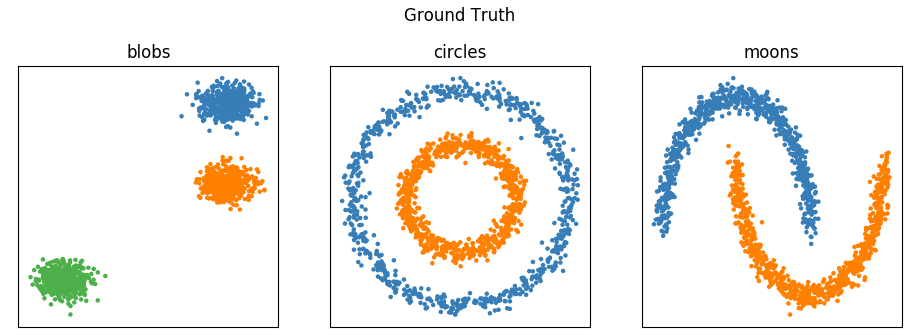

In [2]:
preds = [datasets[key][1] for key in sorted_keys]

plot_clustering_results(datasets, sorted_keys, preds, suptitle="Ground Truth")

## K-Means Clustering

* A form of partitioning: divide points into $k$ clusters $C_1, ..., C_k$.  Cluster membership is mutually exclusive ($C_k \cap C_{k'}$ for $k \neq k'$).
* Each cluster defined by a **centroid**

$$
\mu_k = \frac{1}{|C_k|}\sum_{i'\in C_k}\vec{x}_{i'}
$$

* Observations are clustered based on distance to nearest centroid.

* K-means aims to minimize **inertia**, or within-cluster variation ($|C_k|$ is number of observations in cluster $C_k$; derivation uses [this identity](https://math.stackexchange.com/a/439238)):

\begin{eqnarray}
I &=& \sum_{k=1}^{K}\frac{1}{|C_k|}\sum_{i,i'\in C_k}|\vec{x}_i - \vec{x}_{i'}|^2 \\
&=& 2\sum_{k=1}^{K}\sum_{i\in C_k}|\vec{x}_i - \mu_k|^2
\end{eqnarray}

* Algorithm:
  1. "Randomly" assign (ie. "seed") a number from $1$ to $K$ to each observation.  (In practice there are better ways to randomly initialize centroids)
  2. Iterate until cluster assignments stop changing (by more than some tolerance):
    1. Compute cluster centroid $\mu_k$
    2. Based on distance measure, assign each observation to closest centroid
* Algorithm is guaranteed to improve $I$, since first step minimizes sum-of-square deviations for each cluster, and second minimizes distance between observations and centroids.
* Animation, from [David Sheehan's blog](https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/):

![k-means algorithm, from David Sheehan](images/kmeans.gif)

* Only $O(KNT)$ ($N$ is number of observations, $T$ number of iterations), making it very fast
* Must manually determine $K$ (see below)
* Algorithm is non-convex ([pg. 16 of these notes](http://www.cs.toronto.edu/~urtasun/courses/CSC411_Fall16/12_clustering.pdf)) and converges to **local** minimum - will want to run clustering multiple times and pick best result.  In sklearn, use `n_init` to run multiple times.  Should also use `init='k-means++'` when using sklearn to optimize seeding
* **Assumes clusters are convex and isotropic** (ie. globular), will cluster poorly if not true!
* Random notes:
  * Equivalent to expectation-maximization algorithm for small, all-equal, diagonal covariance matrix
  * Can implement [cosine-distance](https://stats.stackexchange.com/questions/299013/cosine-distance-as-similarity-measure-in-kmeans) [k-means](https://stackoverflow.com/questions/46409846/using-k-means-with-cosine-similarity-python), but not supported by default in sklearn


<IPython.core.display.Javascript object>


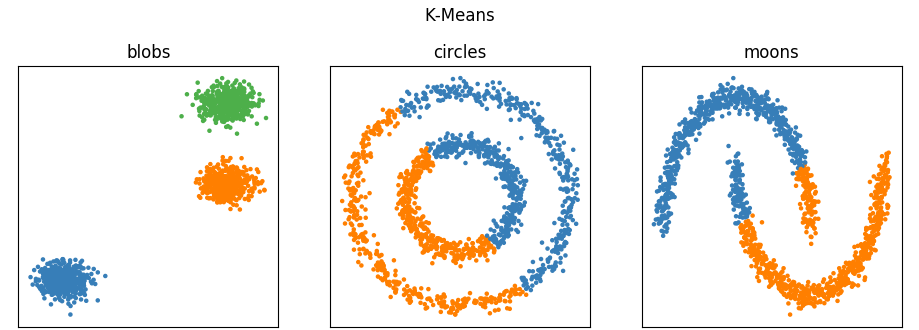

In [3]:
from sklearn.cluster import KMeans
from sklearn.model_selection import ParameterGrid
from sklearn import metrics

# We know k = 3 for the blobs, and 2 for the others.
# This is obviously a hacky use for parameter grid, and in general we shouldn't be doing this...
params = list(ParameterGrid({'n_clusters': [3, 2, 2],  # Number of clusters
                             'init': ['k-means++',],   # Cluster initialization scheme
                             'n_init': [30,]}))        # Number of times to try clustering, picking best out of the bunch

preds = do_clustering(datasets, KMeans, sorted_keys, params, suptitle="K-Means")

In [4]:
# Calculate adjusted Rand index and silhouette scores.

print("Blob Adj. Rand = ", metrics.adjusted_rand_score(datasets['blobs'][1], preds[0]))
print("Blob Silhouette Score = ", metrics.silhouette_score(datasets['blobs'][0], preds[0]))

print("Moons Adj. Rand = ", metrics.adjusted_rand_score(datasets['moons'][1], preds[2]))
print("Moons Silhouette Score = ", metrics.silhouette_score(datasets['moons'][0], preds[2]))

Blob Adj. Rand =  1.0
Blob Silhouette Score =  0.8104321767519068
Moons Adj. Rand =  0.48593091019416684
Moons Silhouette Score =  0.49979294746278263


### Elbow Method

* Whe number of clusters is not a-priori known, can use ["elbow method"](https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion) determine number needed before diminishing returns
* Can be performed using inertia, or cluster evaluation metric
* Typically done by eye, though some crude convergence criterion could be automated

<IPython.core.display.Javascript object>


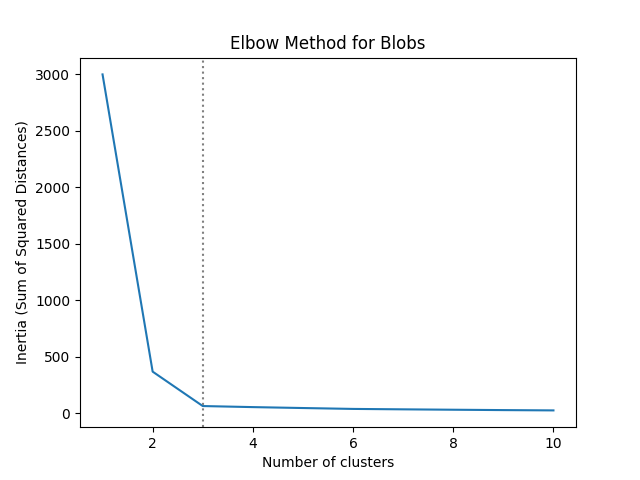

In [5]:
# Perform elbow method on blobs to see if we retrieve k = 3.
# Follows https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion
blob_X = datasets['blobs'][0]

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=30).fit(blob_X)
    inertia.append(kmeans.inertia_)

plt.figure()
plt.plot(np.arange(1, 11), inertia)
plt.axvline(x=3, color='gray', ls=':')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Blobs")
plt.show()

## Agglomerative Hierarchical Clustering

* Builds a tree structure, or **dendrogram**, depicting scale at which groups of observations can be considered one cluster
* "Agglomerative" means bottom-up - start with observations in individual clusters, then increase scale until they're all clustered
* Clustering determined by a scale cutoff
* Animation, from [David Sheehan's blog](https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/):

![agglomerative hierarchical clustering, from David Sheehan](images/hierarch.gif)

* **Dissimilarity measure**, ie. a **distance metric** such as euclidean or manhattan
* **Linkage**: algorithm for the algorithm to measure dissimilarity between groups of points.  Eg. "complete": largest distance between two groups; "average": mean intragroup dissimilarity; "ward": minimizes variance (these are most popular and tend to lead to balanced dendrograms)
* Algorithm:
  1. Begin with $n$ observations, and treat each as its own cluster
  2. Repeat until there is only one cluster:
     1. Examine all pairwise inter-cluster dissimilarities and find the pair with the smallest dissimilarity.  Fuse the two, and record their dissimilarity (this is used to determine merge height on the dendrogram)
     2. Compute the new pairwise dissimilarities between clusters
* To get a specific number of clusters, impose dissimilarity cutoff.  No need to recalculate entire tree for a different cluster number (sklearn's implementation requires passing a number of clusters though)
* Can also [constrain connectivity](http://scikit-learn.org/stable/modules/clustering.html#adding-connectivity-constraints) to get clustering on non-convex shapes (see also David Sheehan's blog)
* Between $O(N^2)$ and $O(N^2log(N))$ (requires heap; $O(N^2)$ memory), depending on how linkage is chosen and whether nearest neighbours are pre-computed, so quite expensive!

<IPython.core.display.Javascript object>


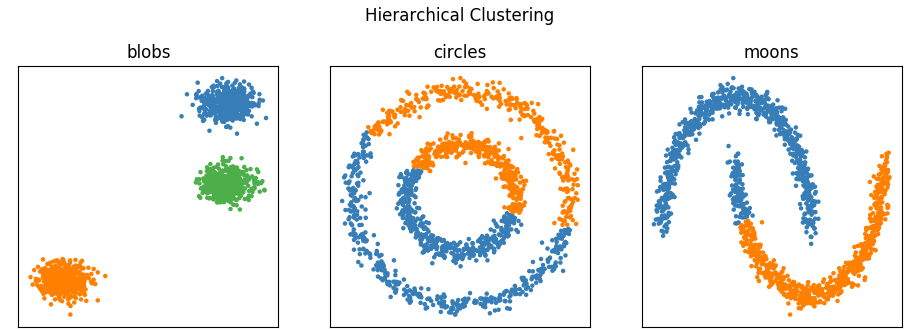

In [6]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# We know k = 3 for the blobs, and 2 for the others.
params = list(ParameterGrid({'n_clusters': [3, 2, 2],  # Number of clusters
                             'affinity': ['euclidean',],   # Metric
                             'linkage': ['average',]}))   # Linkage

preds = do_clustering(datasets, AgglomerativeClustering, sorted_keys, params, suptitle="Hierarchical Clustering")

<IPython.core.display.Javascript object>


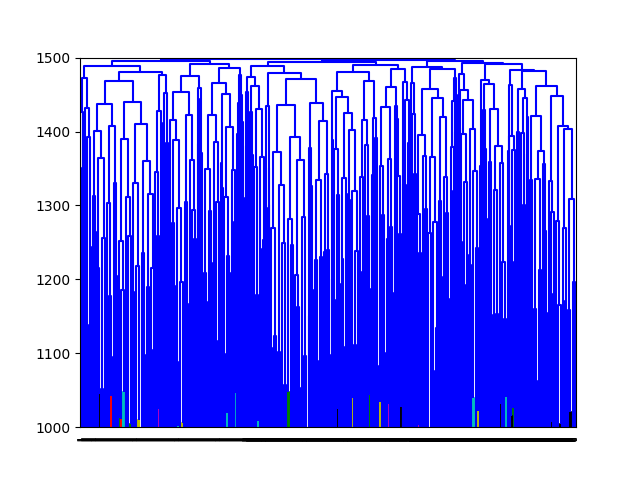

In [7]:
# From https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

blob_aggc = AgglomerativeClustering(
    affinity='euclidean', n_clusters=3, linkage='complete').fit(datasets['blobs'][0])

plt.figure()
plot_dendrogram(blob_aggc, labels=blob_aggc.labels_)
plt.ylim([1000, 1500])
plt.show()

/home/cczhu/pythonenv/ml3/lib/python3.5/site-packages/sklearn/cluster/hierarchical.py:479: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)
/home/cczhu/pythonenv/ml3/lib/python3.5/site-packages/sklearn/cluster/hierarchical.py:479: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)


<IPython.core.display.Javascript object>


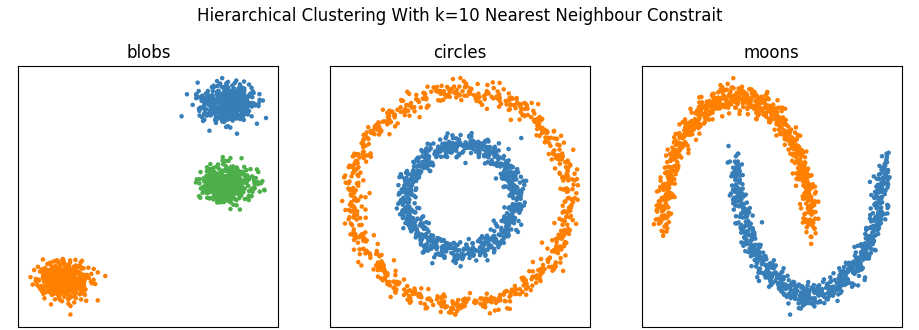

In [8]:
# To restrict clustering to the nearest 10 neighbours, let's append a connectivity matrix to the parameters
# See the User Guide: http://scikit-learn.org/stable/modules/neighbors.html#unsupervised-neighbors
connectivity_mtxs = []
for key in sorted_keys:
    connectivity = kneighbors_graph(datasets[key][0], n_neighbors=10, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    connectivity_mtxs.append(connectivity)

# We know k = 3 for the blobs, and 2 for the others.
params = list(ParameterGrid({'n_clusters': [3, 2, 2],  # Number of clusters
                             'affinity': ['euclidean',],   # Metric
                             'linkage': ['average',]}))   # Linkage
for i in range(3):
    params[i]['connectivity'] = connectivity_mtxs[i]

preds = do_clustering(datasets, AgglomerativeClustering,
                      sorted_keys, params,
                      suptitle="Hierarchical Clustering With k=10 Nearest Neighbour Constrait")

## DBSCAN

* Algorithm that picks out groups of sufficient density from uniform lower-density background
* Treats background as "noise"
* Cluster defined as maximal set of density-connected points (see algorithm below)
* Clusters are 
* Algorithm - repeated until there are no more observations:
  1. Pick a random observation that has not yet been classified.
  2. Until no more points can be walked to:
    1. Determine if there are more than the minimum number of points `min_pts` within a radius `epsilon`.  If so, label the point as a "core point".  If not, label it a "border point" if the algorithm got here by walking from a core point, or "background" if it didn't.
    2. If the point is a core point, walk to all its neighbours (within `epsilon`) and repeat the process with each of them.

* Animation, from [David Sheehan's blog](https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/):

![DBSCAN, from David Sheehan](images/DBSCAN.gif)

* $O(Nlog(N))$ if nearest neighbours have been pre-calculated; $O(N^2)$ otherwise
* [See these videos](https://www.coursera.org/lecture/cluster-analysis/5-1-density-based-and-grid-based-clustering-methods-HIRhw) for more info

<IPython.core.display.Javascript object>


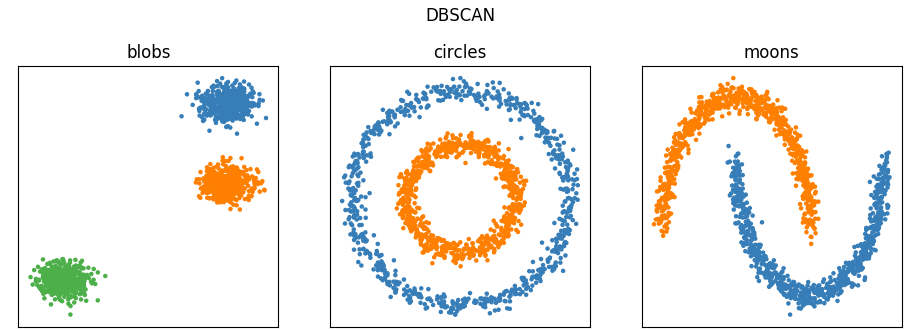

In [9]:
from sklearn.cluster import DBSCAN

# We know k = 3 for the blobs, and 2 for the others.
params = list(ParameterGrid({'min_samples': [5,],  # Number of clusters
                             'eps': [0.3, 0.3, 0.3]}))   # Linkage

preds = do_clustering(datasets, DBSCAN, sorted_keys, params, suptitle="DBSCAN")

In [10]:
# Let's try a clustering that leads to noise.
varied = ds.make_blobs(n_samples=1500,
                       cluster_std=[1.0, 2.5, 0.5],
                       random_state=170)
varied_X_scaled = StandardScaler().fit_transform(varied[0])
dbscan = DBSCAN(eps=0.18, min_samples=10).fit(varied_X_scaled)

<IPython.core.display.Javascript object>


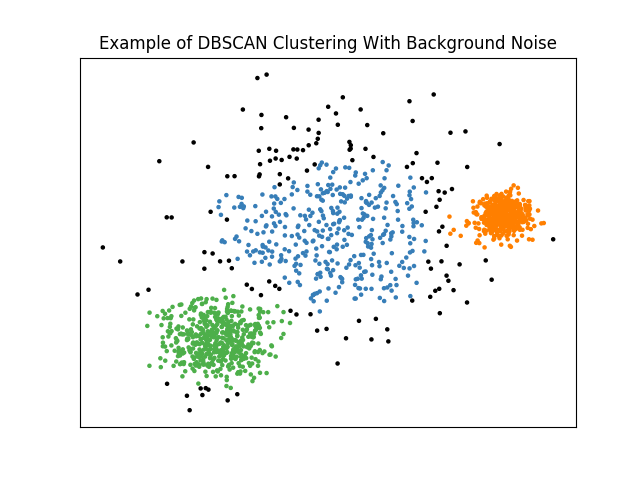

Text(0.5, 1.0, 'Example of DBSCAN Clustering With Background Noise')

In [11]:
plt.figure()
plt.scatter(varied_X_scaled[:, 0], varied_X_scaled[:, 1],
            s=5, color=colors[dbscan.labels_])
plt.show()
plt.xticks(())
plt.yticks(())
plt.title("Example of DBSCAN Clustering With Background Noise")